In [ ]:
# Esse programa foi apresentado como projeto final da disciplina EE881 no segundo semestre de 2019.

# Alunos: Sara Sousa de Oliveira (RA: 205733)
#         Luiz Henrique Costa Freitas (RA: 202403)
# Professor: Renato Lopes

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal

# Para detectar sincronismo.
from scipy import signal as sig
import random
import pandas as pd

import app_decoder

Taxa de acerto: 1.0
Uma noite destas, vindo da cidade para o Engenho Novo, encontrei num trem da Central um rapaz aqui do bairro, que eu conheco de vista e de chapeu.


In [2]:
# leitura de txt (header):

header = open('header.txt', 'r', encoding="utf-8")
header = header.read()
header = header.replace("[", "")
header = header.replace("]", "")
header = header.replace(",", "")

header = np.fromstring(header, dtype=int, sep=' ')
print(header)
print(type(header[2]))
print(len(header))

[1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0
 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1
 1]
<class 'numpy.int64'>
75


In [3]:
print("Digite o número de modulações que o detector irá detectar (2 ou 4): ")
n = input()
n = int(n)

Digite o número de modulações que o detector irá detectar (2 ou 4): 
2


In [4]:
print("Digite a taxa de transmissão de preferência (Tb): ")
baudRate = input()
baudRate = int(baudRate)

Digite a taxa de transmissão de preferência (Tb): 
20


# 2-FSK (se n = 2)

Dados do áudio:  [-6.10351562e-05 -1.52587891e-04 -1.83105469e-04 ...  6.10351562e-05
 -1.52587891e-04  2.44140625e-04]
Tamanho dos dados:  1663200
Sample rate of the audio:  24000
Amostras por símbolo:  1200.0
[1.         0.95105652 0.80901699 ... 0.58778525 0.80901699 0.95105652]


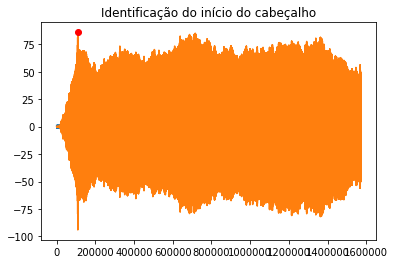

Amostra de começo do header:  109267
90000
[ 7.62939453e-04  4.57763672e-04 -3.66210938e-04 ...  6.10351562e-05
 -1.52587891e-04  2.44140625e-04]
1463933
Tamanho do data:  1463933
Tamanho do vetor após convolução:  1465731


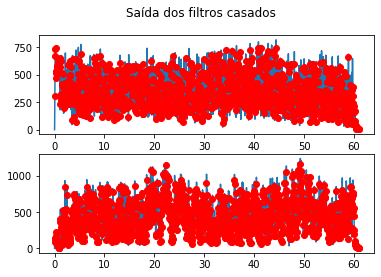

Taxa de acerto: 0.7328767123287672
U]A OýöQ TWÿþPûº ~}ßô_ðTQðRÿÜPÔW`|Pp _à_ÿ÷ßþðOÿÿÿÿ Gçÿþ~wÝ ÿßð~~ÿ ` gþ~raL u} ra|` `q} doàbam~voî ÿàgÿôwÿÿü÷ÿðvWðÿþu°WðVwðsÿßÿßÿÿ


In [7]:
if n == 2:

    # Leitura de .wav
    
    data, Fs = sf.read('teste1_2fsk.wav') 
    print("Dados do áudio: ", data)
    print("Tamanho dos dados: ", len(data))
    print("Sample rate of the audio: ", Fs)
    
    
    # Cálculo de up sample (amostras por símbolo).
    
    up_sample = Fs/baudRate
    print("Amostras por símbolo: ", up_sample)
    
    
    # Modulação do header (Feito só para o 2FSK). 
    
    F1=800
    F2=1200
    t_wave=np.arange(0,1/baudRate,1/Fs)         # Limita meu sinal em um tempo determinado.
    
    header_modulado = []
    tam = len(header)
    cosseno_F1 = np.cos(2*np.pi*F1*t_wave)
    cosseno_F2 = np.cos(2*np.pi*F2*t_wave)
    
    for i in range(0, tam, 1):
        
        if header[i]==0:
            x = (cosseno_F1)
            header_modulado = np.append(header_modulado, x)
        elif header[i]==1:
            x = (cosseno_F2)
            header_modulado = np.append(header_modulado, x)
            
    print(header_modulado)
    len(header_modulado)
    
    
    # Plot do header modulado (não deu para ver a mudança de frequência).
    
    t = np.arange(0,len(header_modulado),1)  
    fig = plt.figure()
    plt.plot(t, header_modulado)
    fig.savefig('plot.png')
    header_modulado
    
    
    # Aqui eu tenho que descobrir onde o sinal começa. Achar o cabeçalho e ver onde sinal começa (start_bit). 
    # Isso pode ser feito com uma função de correlação (o valor deve ser máximo para o atraso estar sincronizado).
    
    corr = np.correlate(data,header_modulado,mode='valid')
    corr_position = np.argmax(corr)
    start_bit = corr_position
    
    
    # Plot da correlação cruzada
    
    plt.plot(corr)
    plt.title('Identificação do início do cabeçalho')
    plt.plot(corr_position,corr[corr_position],'or')
    plt.show()
    
    
    # Start bit é a amostra de começo do header.
    
    print("Amostra de começo do header: ", start_bit)
    print(len(header_modulado))
    
    
    # Somamos a amostra de começo do header o tamanho do header.
    
    start = start_bit + len(header_modulado)    
            
    
    # Pegar dados a partir de onde começa a mensagem.
    
    data = data[start:]
    print(data)
    print(len(data))
    
    
    # Construção das ondas da portadora do 2-FSK. Cada "ramo" com uma frequência.
    
    F1=800
    F2=1200
    t_wave=np.arange(0,1/baudRate,1/Fs)
    
    wave1=np.cos(2*np.pi*F1*t_wave)
    wave2=np.cos(2*np.pi*F2*t_wave)
    
    
    # Aplicação do filtro casado + média móvel.
    
    casado_1=np.convolve(data,np.flip(wave1))          # Precisa-se inverter pq o filtro casado é h(-t).
    casado_1=np.convolve(np.abs(casado_1),np.ones((int(len(t_wave)/2))))
    casado_2=np.convolve(data,np.flip(wave2))
    casado_2=np.convolve(np.abs(casado_2),np.ones((int(len(t_wave)/2))))
    
    
    # debug
    
    print("Tamanho do data: ", len(data))
    print("Tamanho do vetor após convolução: ", len(casado_1))
    
    
    # Amostragem do filtro casado a cada período de bit. Pego só última amostra para representar meu símbolo.
    # Por causa da média móvel e da envoltória, esse ponto que eu pegar vai ser meu símbolo.
    
    t = np.arange(0,len(data)/Fs,1/Fs)
    
    step=int(Fs/baudRate)
    
    amostra_casado1=casado_1[step::step]
    amostra_casado2=casado_2[step::step]
    
    t_amostra=np.arange(step/Fs,t[-1]+step/Fs,step/Fs)
    
    
    # Plot da saída dos filtros casados.
    
    t = np.arange(0,len(data)/Fs,1/Fs) 
    
    fig, axs = plt.subplots(2)
    fig.suptitle('Saída dos filtros casados')
    axs[0].plot(t,casado_1[0:len(t)])
    axs[0].plot(t_amostra,amostra_casado1[0:len(t_amostra)],'or')
    axs[1].plot(t,casado_2[0:len(t)])
    axs[1].plot(t_amostra,amostra_casado2[0:len(t_amostra)],'or')
    plt.show()
    fig.savefig('saida_casada.png')
    
    
    
    # Coparação posição a posição do vetor de saída de cada filtro.
    
    a1 = len(amostra_casado1)
    a2 = len(amostra_casado2)
    vetor_final = []
    
    for i in range(0, a1, 1):
        if amostra_casado1[i]>amostra_casado2[i]:
            vetor_final.append(0)
        elif amostra_casado1[i]<amostra_casado2[i]:
            vetor_final.append(1)
            
    app_decoder.app_decoder(vetor_final)

# 4FSK ( se n = 4)

In [6]:
if n == 4:

    # Leitura de .wav
    
    data, Fs = sf.read('4fsk_sala_cel.wav') 
    print("Dados do áudio: ", data)
    print("Tamanho dos dados: ", len(data))
    print("Sample rate of the audio: ", Fs)
    
    
    # Portadoras da 4-FSK
    
    F1=600
    F2=800
    F3=1000
    F4=1200
    
    t_wave=np.arange(0,1/baudRate,1/Fs)
    
    wave1=np.cos(2*np.pi*F1*t_wave)
    wave2=np.cos(2*np.pi*F2*t_wave)
    wave3=np.cos(2*np.pi*F3*t_wave)
    wave4=np.cos(2*np.pi*F4*t_wave)

    
    
    # Aplicação do filtro casado + média móvel.
    
    casado_1=np.convolve(data,np.flip(wave1))
    casado_1=np.convolve(np.abs(casado_1),np.ones((int(len(t_wave)/2))))
    
    casado_2=np.convolve(data,np.flip(wave2))
    casado_2=np.convolve(np.abs(casado_2),np.ones((int(len(t_wave)/2))))
    
    casado_3=np.convolve(data,np.flip(wave3))
    casado_3=np.convolve(np.abs(casado_3),np.ones((int(len(t_wave)/2))))
    
    casado_4=np.convolve(data,np.flip(wave4))
    casado_4=np.convolve(np.abs(casado_4),np.ones((int(len(t_wave)/2))))
    
    
    #Amostragem do filtro casado a cada período de bit
    
    t = np.arange(0,len(data)/Fs,1/Fs)
    
    step=int(Fs/baudRate)
    
    amostra_casado1=casado_1[step::step]
    amostra_casado2=casado_2[step::step]
    amostra_casado3=casado_3[step::step]
    amostra_casado4=casado_4[step::step]
    t_amostra=np.arange(step/Fs,t[-1]+step/Fs,step/Fs)
    
    
    # debug
    
    print("Número de símbolos: ", len(amostra_casado1))      # esse valor nos dá o número de símbolos.
    
    
    # Plot da saída dos filtros casados.
    
    fig, axs = plt.subplots(4)
    fig.suptitle('Saída dos filtros casados')
    axs[0].plot(t,casado_1[0:len(t)])
    axs[0].plot(t_amostra,amostra_casado1[0:len(t_amostra)],'or')
    axs[1].plot(t,casado_2[0:len(t)])
    axs[1].plot(t_amostra,amostra_casado2[0:len(t_amostra)],'or')
    axs[2].plot(t,casado_3[0:len(t)])
    axs[2].plot(t_amostra,amostra_casado3[0:len(t_amostra)],'or')
    axs[3].plot(t,casado_4[0:len(t)])
    axs[3].plot(t_amostra,amostra_casado4[0:len(t_amostra)],'or')
    plt.show()
    
    
    
    # Comparação posição a posição do vetor de saída de cada filtro.
    
    a1 = len(amostra_casado1)
    vetor_final4 = []
    
    for i in range(0, a1, 1):
        if amostra_casado1[i]>amostra_casado2[i] and amostra_casado1[i]>amostra_casado3[i] and amostra_casado1[i]>amostra_casado4[i]:        
            vetor_final4.append(0)
            vetor_final4.append(0)
        elif amostra_casado2[i]>amostra_casado1[i] and amostra_casado2[i]>amostra_casado3[i] and amostra_casado2[i]>amostra_casado4[i]:
            vetor_final4.append(0)
            vetor_final4.append(1)
        elif amostra_casado3[i]>amostra_casado1[i] and amostra_casado3[i]>amostra_casado2[i] and amostra_casado3[i]>amostra_casado4[i]:
            vetor_final4.append(1)
            vetor_final4.append(1)
        elif amostra_casado4[i]>amostra_casado1[i] and amostra_casado4[i]>amostra_casado2[i] and amostra_casado4[i]>amostra_casado3[i]:
            vetor_final4.append(1)
            vetor_final4.append(0)
    
    print(type(vetor_final4))
    vetor_final4 = list(vetor_final4)
    print(len(vetor_final4))
    
    
    # Aqui eu tenho que descobrir onde o sinal começa (start_bit). 
    # Isso pode ser feito com uma função de correlação (o valor deve ser máximo para o atraso estar sincronizado).
    
    corr = np.correlate(vetor_final4,header,mode='valid')
    corr_position = np.argmax(corr)
    start_bit = corr_position
    print("Posição de início do cabeçalho: ", start_bit)
    
    #Plot da correlação cruzada
    
    plt.plot(corr)
    plt.title('Identificação do início do cabeçalho')
    plt.plot(corr_position,corr[corr_position],'or')
    plt.show()
    
    
    start = start_bit + len(header)
    vetor_final4 = vetor_final4[start:]
    
    print("Tamanho do vetor do 4-FSK", len(vetor_final4))
    print(vetor_final4)
    app_decoder.app_decoder(vetor_final4)